In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import Binarizer, OrdinalEncoder, power_transform, PolynomialFeatures

## Data Analysis

#### 1. Metadata

In [2]:
data = pd.read_csv('Data_for_UCI_named.csv')
print('data shape:', data.shape)
print('is null:', np.sum(data.isnull()).values)
enc = OrdinalEncoder()
enc.fit(data[['stabf']])
data.stabf = enc.transform(data[['stabf']])
data.head()

data shape: (10000, 14)
is null: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1.0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0.0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1.0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1.0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1.0


#### 2. Relation between variable and stab

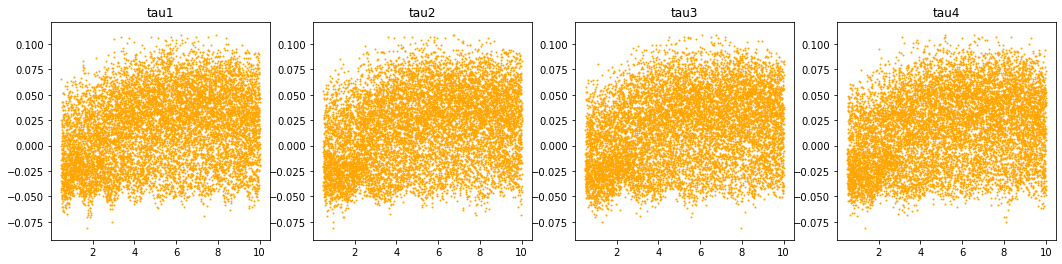

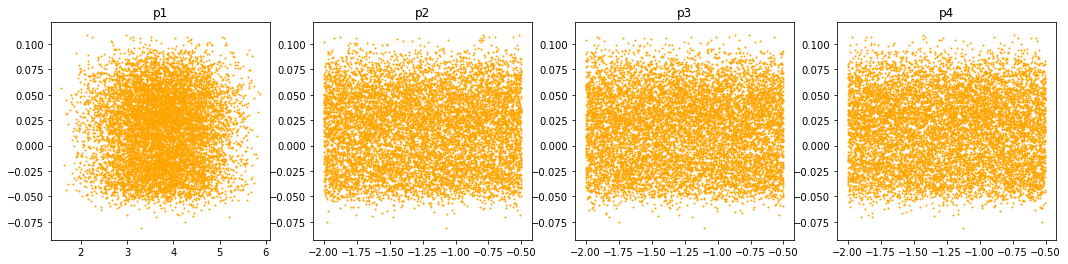

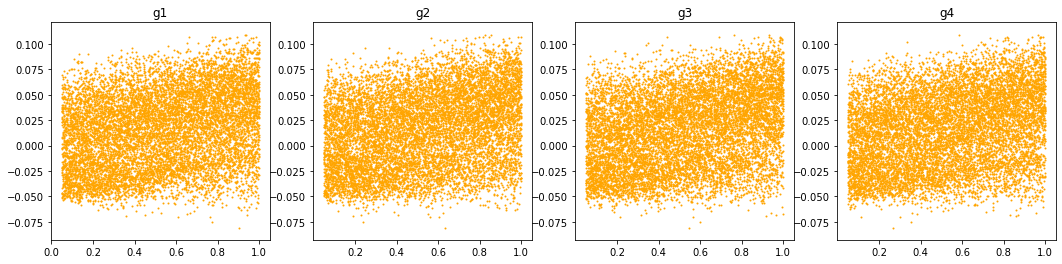

In [3]:
for i in range(3):
    plt.figure(figsize=(18, 4))
    for j in range(4):
        ax = plt.subplot(1, 4, j+1)
        ax.set_title(data.columns[i*4+j])
        ax.scatter(data.iloc[:, i*4+j], data.stab, s=1, c='orange')
    plt.show()

#### 3. Data correlation

In [4]:
df = data.corr()
df.style.background_gradient().set_precision(2)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
tau1,1.00,0.02,-0.01,-0.02,0.03,-0.02,-0.02,-0.02,0.01,0.02,-0.00,0.01,0.28,0.23
tau2,0.02,1.00,0.01,-0.00,-0.00,0.01,0.01,-0.01,-0.00,0.02,0.02,-0.01,0.29,0.25
tau3,-0.01,0.01,1.00,0.00,0.02,-0.00,-0.01,-0.02,-0.01,0.01,0.01,-0.01,0.28,0.24
tau4,-0.02,-0.00,0.00,1.00,-0.00,0.01,0.01,-0.01,-0.00,0.01,0.00,-0.00,0.28,0.24
p1,0.03,-0.00,0.02,-0.00,1.00,-0.57,-0.58,-0.58,0.00,0.02,0.00,-0.02,0.01,0.01
p2,-0.02,0.01,-0.00,0.01,-0.57,1.00,0.00,-0.01,0.02,-0.02,0.01,0.02,0.01,0.01
p3,-0.02,0.01,-0.01,0.01,-0.58,0.00,1.00,0.01,-0.00,-0.01,-0.01,-0.01,-0.00,-0.00
p4,-0.02,-0.01,-0.02,-0.01,-0.58,-0.01,0.01,1.00,-0.01,0.00,-0.00,0.02,-0.02,-0.02
g1,0.01,-0.00,-0.01,-0.00,0.00,0.02,-0.00,-0.01,1.00,0.01,-0.01,0.01,0.28,0.20
g2,0.02,0.02,0.01,0.01,0.02,-0.02,-0.01,0.00,0.01,1.00,-0.01,-0.01,0.29,0.22


## Modeling

In [5]:
x, y = data.drop(columns=['stab', 'stabf']), data[['stab', 'stabf']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5000, 12), (5000, 12), (5000, 2), (5000, 2))

In [6]:
def train(X, X_, Y, Y_, colname):
    reg = LassoLarsIC(criterion='bic', eps=1e-5).fit(X, Y.stab)
    print('train R^2: %.4f  test R^2: %.4f'%(reg.score(X, Y.stab), reg.score(X_, Y_.stab)))
    for i in range(2):
        _X = X.copy() if i == 0 else X_.copy()
        _Y = Y.copy() if i == 0 else Y_.copy()
        text = 'train acc: %.4f  ' if i == 0 else 'test acc: %.4f\n\n'
        s = Binarizer().transform(reg.predict(_X).reshape(-1,1))
        sf = pd.DataFrame(s, index=_Y.index, columns=['f'])
        print(text%np.mean(sf.f == _Y.stabf), end='')
        
    print('important coef length: %d/%d'%(len(np.where(reg.coef_ != 0)[0]), len(reg.coef_)))
    j = 0
    for i in  np.where(reg.coef_ != 0)[0]:
        print('%10s: %.4f'%(np.array(colname)[i], reg.coef_[i]), end = '\t')
        j += 1
        if j % 4 == 0:
            print()
        
    residual = Y_.stab - reg.predict(X_)
    
    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.scatter(Y_.index,residual, s=5, c='orange')
    plt.plot((0,10000), (0,0), c='b')
    plt.subplot(1,2,2)
    stats.probplot(residual, dist="norm", plot=plt)
    plt.show()
    return colname[np.where(reg.coef_ == 0)[0]]

#### 1. Fitting raw data

train R^2: 0.6437  test R^2: 0.6461
train acc: 0.8164  test acc: 0.8146

important coef length: 8/12
      tau1: 0.0034	      tau2: 0.0036	      tau3: 0.0036	      tau4: 0.0036	
        g1: 0.0360	        g2: 0.0365	        g3: 0.0380	        g4: 0.0367	


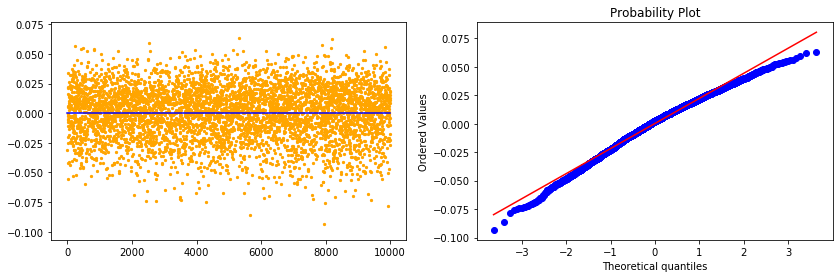

In [7]:
dropcol = train(x_train, x_test, y_train, y_test, x_train.columns)

#### 2. Fitting data with power transform

train R^2: 0.6657  test R^2: 0.6688
train acc: 0.8208  test acc: 0.8212

important coef length: 8/12
      tau1: 0.0096	      tau2: 0.0102	      tau3: 0.0102	      tau4: 0.0103	
        g1: 0.0099	        g2: 0.0100	        g3: 0.0105	        g4: 0.0101	


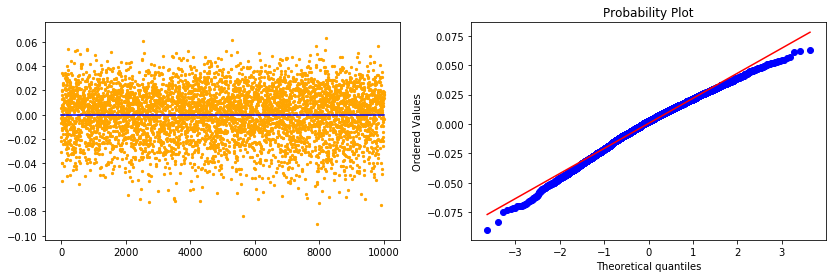

In [8]:
df = x_train
powx_train = pd.DataFrame(power_transform(df, method='yeo-johnson'), columns=x_train.columns)
df = x_test
powx_test = pd.DataFrame(power_transform(df, method='yeo-johnson'), columns=x_train.columns)
_ = train(powx_train, powx_test, y_train, y_test, x_train.columns)

#### 3. Fitting data with interaction term only

train R^2: 0.7320  test R^2: 0.7283
train acc: 0.8590  test acc: 0.8578

important coef length: 14/37
        g1: 0.0060	        g2: 0.0059	        g3: 0.0029	        g4: 0.0044	
 tau1 tau2: 0.0000	 tau1 tau3: 0.0000	 tau1 tau4: 0.0000	   tau1 g1: 0.0059	
 tau2 tau3: 0.0000	 tau2 tau4: 0.0001	   tau2 g2: 0.0057	   tau3 g3: 0.0064	
   tau4 g4: 0.0065	     g2 g3: 0.0025	

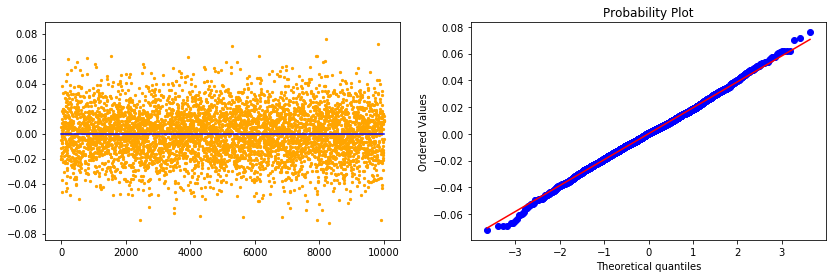

In [9]:
poly = PolynomialFeatures(2, interaction_only=True)
newx_train = poly.fit_transform(x_train.drop(columns=dropcol))
newx_test = poly.fit_transform(x_test.drop(columns=dropcol))
colname = poly.get_feature_names(x_train.drop(columns=dropcol).columns)
_ = train(newx_train, newx_test, y_train, y_test, np.array(colname))

#### 4. Fitting data with second order interaction

train R^2: 0.8673  test R^2: 0.8668
train acc: 0.9318  test acc: 0.9304

important coef length: 21/45
      tau1: 0.0028	      tau2: 0.0031	      tau3: 0.0033	      tau4: 0.0029	
    tau1^2: -0.0007	 tau1 tau2: 0.0003	 tau1 tau3: 0.0003	 tau1 tau4: 0.0003	
   tau1 g1: 0.0072	    tau2^2: -0.0007	 tau2 tau3: 0.0003	 tau2 tau4: 0.0003	
   tau2 g2: 0.0069	    tau3^2: -0.0007	 tau3 tau4: 0.0002	   tau3 g3: 0.0073	
    tau4^2: -0.0007	   tau4 g4: 0.0074	      g1^2: 0.0003	      g2^2: 0.0017	
      g3^2: 0.0003	

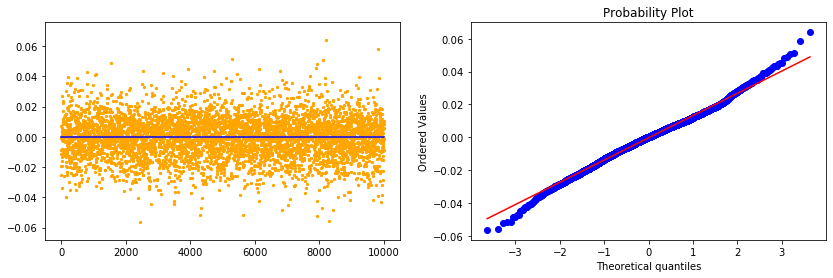

In [10]:
poly = PolynomialFeatures(2)
newx_train = poly.fit_transform(x_train.drop(columns=dropcol))
newx_test = poly.fit_transform(x_test.drop(columns=dropcol))
colname = poly.get_feature_names(x_train.drop(columns=dropcol).columns)
_ = train(newx_train, newx_test, y_train, y_test, np.array(colname))

#### 5. Fitting data with third order interaction

train R^2: 0.9255  test R^2: 0.9254
train acc: 0.9524  test acc: 0.9482

important coef length: 48/165
        g1: 0.0011	 tau1 tau2: 0.0001	 tau1 tau3: 0.0001	 tau1 tau4: 0.0001	
   tau1 g1: 0.0170	 tau2 tau3: 0.0002	 tau2 tau4: 0.0001	   tau2 g2: 0.0167	
 tau3 tau4: 0.0001	   tau3 g3: 0.0162	   tau4 g4: 0.0169	      g1^2: 0.0013	
 tau1^2 g1: -0.0012	 tau1^2 g2: -0.0002	 tau1^2 g3: -0.0002	 tau1^2 g4: -0.0002	
tau1 tau2 g1: 0.0002	tau1 tau2 g2: 0.0002	tau1 tau3 g1: 0.0002	tau1 tau3 g3: 0.0001	
tau1 tau4 g1: 0.0002	tau1 tau4 g4: 0.0001	tau1 g2 g4: -0.0001	    tau2^3: -0.0000	
 tau2^2 g1: -0.0002	 tau2^2 g2: -0.0011	 tau2^2 g3: -0.0002	 tau2^2 g4: -0.0001	
tau2 tau3 g3: 0.0002	tau2 tau4 g2: 0.0002	tau2 tau4 g4: 0.0001	tau2 g1 g3: -0.0002	
 tau2 g2^2: 0.0001	    tau3^3: -0.0000	 tau3^2 g1: -0.0002	 tau3^2 g2: -0.0001	
 tau3^2 g3: -0.0011	 tau3^2 g4: -0.0002	tau3 tau4 g3: 0.0001	tau3 tau4 g4: 0.0001	
 tau4^2 g1: -0.0002	 tau4^2 g2: -0.0002	 tau4^2 g3: -0.0001	 tau4^2 g4: -0.0011	
 tau4 g4

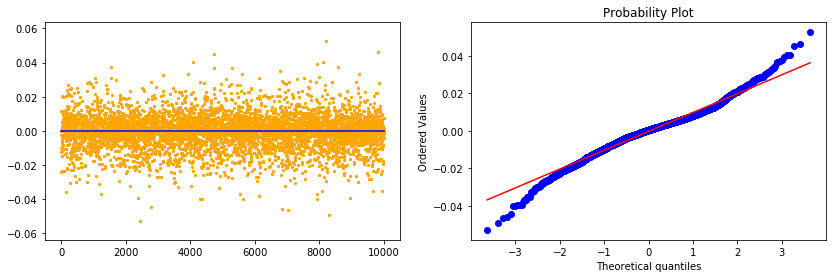

In [11]:
poly = PolynomialFeatures(3)
newx_train = poly.fit_transform(x_train.drop(columns=dropcol))
newx_test = poly.fit_transform(x_test.drop(columns=dropcol))
colname = poly.get_feature_names(x_train.drop(columns=dropcol).columns)
_ = train(newx_train, newx_test, y_train, y_test, np.array(colname))

#### 6. Fitting data with fourth order interaction

train R^2: 0.9281  test R^2: 0.9282
train acc: 0.9514  test acc: 0.9512

important coef length: 60/495
   tau1 g1: 0.0117	 tau2 tau3: 0.0001	   tau2 g2: 0.0118	 tau3 tau4: 0.0000	
   tau3 g3: 0.0118	   tau4 g4: 0.0117	      g1^2: 0.0011	tau1 tau2 g1: 0.0002	
tau1 tau2 g2: 0.0002	tau1 tau3 g1: 0.0002	tau1 tau3 g3: 0.0002	tau1 tau4 g1: 0.0003	
tau1 tau4 g4: 0.0002	 tau1 g1^2: 0.0001	tau2 tau3 g2: 0.0001	tau2 tau3 g3: 0.0002	
tau2 tau4 g2: 0.0002	tau2 tau4 g4: 0.0002	 tau2 g2^2: 0.0002	tau3 tau4 g3: 0.0002	
tau3 tau4 g4: 0.0002	 tau4 g4^2: 0.0004	  g1 g2 g4: 0.0027	  g2 g3 g4: 0.0005	
 tau1^3 g1: -0.0001	 tau1^3 g2: -0.0000	 tau1^3 g3: -0.0000	 tau1^3 g4: -0.0000	
tau1^2 g1 g2: -0.0001	tau1^2 g1 g3: -0.0001	tau1^2 g1 g4: -0.0002	tau1^2 g2 g3: -0.0001	
tau1^2 g2 g4: -0.0001	 tau2^3 g1: -0.0000	 tau2^3 g2: -0.0001	 tau2^3 g3: -0.0000	
 tau2^3 g4: -0.0000	tau2^2 g1 g2: -0.0002	tau2^2 g1 g3: -0.0001	tau2^2 g2 g3: -0.0001	
tau2^2 g2 g4: -0.0001	tau2^2 g3 g4: -0.0001	 tau3^3 g1: -0.0000	 tau3^3

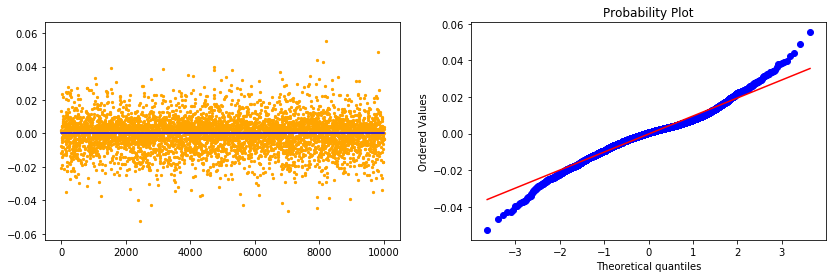

In [12]:
poly = PolynomialFeatures(4)
newx_train = poly.fit_transform(x_train.drop(columns=dropcol))
newx_test = poly.fit_transform(x_test.drop(columns=dropcol))
colname = poly.get_feature_names(x_train.drop(columns=dropcol).columns)
_ = train(newx_train, newx_test, y_train, y_test, np.array(colname))